# 1. Setup

## 1.1. Import statements

In [1]:
%matplotlib inline

In [2]:
import os

os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'backend:cudaMallocAsync'

print(os.environ.get('PYTORCH_CUDA_ALLOC_CONF'))

backend:cudaMallocAsync


In [3]:
import torch
import torch.nn as nn
import time
import gc
import matplotlib.pyplot as plt
from torchinfo import summary
from tqdm import tqdm
from PIL import Image
from torch.utils.data import DataLoader, random_split
from torch.amp import autocast, GradScaler
from torchvision.transforms import v2
from torchvision.datasets import ImageFolder

## 1.2. Device configuration

In [4]:
def get_device() -> torch.device:
    """Get the best available device for PyTorch."""
    if torch.cuda.is_available():
        device = "cuda"

        # The flag below controls whether to allow TF32 on matmul.
        torch.backends.cuda.matmul.allow_tf32 = True
        # The flag below controls whether to allow TF32 on cuDNN.
        torch.backends.cudnn.allow_tf32 = True

        # Print GPU info
        print(f"Using CUDA device: {torch.cuda.get_device_name(0)}")
        
        # Set up GPU memory management
        memory_limit_mb = 4095.5  # Adjust as needed

        total_memory = torch.cuda.get_device_properties(0).total_memory

        memory_limit = memory_limit_mb * 1024 ** 2
        memory_fraction = memory_limit / total_memory

        torch.cuda.set_per_process_memory_fraction(memory_fraction, device=0)

        print(f"Set GPU memory fraction to {memory_fraction:.2%}")

        # Ensure memory is allocated
        torch.cuda.empty_cache()
    elif torch.backends.mps.is_available():
        device = "mps"
        print("Using Apple Silicon MPS device")
    else:
        device = "cpu"
        print("Using CPU device")
    
    return torch.device(device)

In [5]:
torch.set_float32_matmul_precision('high')
device = get_device()

Using CUDA device: NVIDIA GeForce RTX 3050 Ti Laptop GPU
Set GPU memory fraction to 100.00%


In [6]:
pin_memory = True if device.type == 'cuda' else False
pin_memory_device = 'cuda' if device.type == 'cuda' else ''

# 2. Load & transform data

## 2.1. Normalize the dataset

In [7]:
# First, create transforms without normalization to calculate dataset statistics
initial_transforms = v2.Compose([
    v2.Resize((512, 288)),# changed from v1
    v2.Grayscale(num_output_channels=1),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True)
])

In [8]:
# Create temporary dataset to calculate mean and std
temp_dataset = ImageFolder(root='../data/data_pool', transform=initial_transforms)

temp_loader = DataLoader(temp_dataset, batch_size=64, shuffle=False, num_workers=6, pin_memory=pin_memory, pin_memory_device=pin_memory_device)

In [9]:
calc_stats = False

if calc_stats:
    print(f"Computing dataset statistics using device: {device}")
    print(f"Number of images to process: {len(temp_dataset)}")

    channels_sum = torch.zeros(3, device=device)
    channels_sqrd_sum = torch.zeros(3, device=device)
    num_batches = 0
    start_time = time.time()

    for batch_idx, (data, _) in enumerate(tqdm(temp_loader, desc="Computing mean/std")):
        data = data.to(device, non_blocking=True)  # Add non_blocking=True
        with autocast(device.type):
            channels_sum += torch.mean(data, dim=[0, 2, 3])
            channels_sqrd_sum += torch.mean(data ** 2, dim=[0, 2, 3])
        num_batches += 1
        
        if batch_idx % 10 == 0:
            batch_time = time.time() - start_time
            print(f"\nProcessed {batch_idx * temp_loader.batch_size} images in {batch_time:.2f}s")

    mean = channels_sum / num_batches
    std = torch.sqrt((channels_sqrd_sum / num_batches) - (mean ** 2))

    mean = mean.cpu().tolist()
    std = std.cpu().tolist()

    total_time = time.time() - start_time
    print(f"\nTotal processing time: {total_time:.2f} seconds")
    print(f"Dataset mean: {mean}")
    print(f"Dataset std: {std}")

    # Release memory
    del temp_dataset, temp_loader, channels_sum, channels_sqrd_sum, data
    gc.collect()

    torch.cuda.empty_cache()
else:
    mean=[0.35439860820770264, 0.35439860820770264, 0.35439860820770264]
    std=[0.20184797048568726, 0.20184797048568726, 0.20184797048568726]

## 2.2. Define transforms

In [10]:
train_transforms = v2.Compose([
    v2.Resize((512, 288)), # changed from v1
    v2.RandomVerticalFlip(p=0.5),
    v2.RandomRotation(degrees=15),
    v2.ColorJitter(brightness=0.3, saturation=0.2),
    v2.RandomAdjustSharpness(sharpness_factor=1.25, p=1.0),  # Subtle sharpness changes
    v2.RandomPerspective(distortion_scale=0.5, p=0.5),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=mean, std=std)
])

In [11]:
val_transforms = v2.Compose([
    v2.Resize((512, 288)),
    v2.RandomAdjustSharpness(sharpness_factor=1.25, p=1.0),  # Subtle sharpness changes
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=mean, std=std),
])

# 3. Partition dataset

In [12]:
# Load the dataset with appropriate transforms
train_data = ImageFolder(root='../data/data_pool', transform=train_transforms)

val_data = ImageFolder(root='../data/validation_pool', transform=val_transforms)

In [13]:
# Create DataLoaders
train_loader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=6, pin_memory=pin_memory, pin_memory_device=pin_memory_device)

val_loader = DataLoader(val_data, batch_size=64, shuffle=False, num_workers=6, pin_memory=pin_memory, pin_memory_device=pin_memory_device)  

# 4. Building the convolutional neural network

In [14]:
# Input shape constants (changed from v1)
IMG_WIDTH = 512
IMG_HEIGHT = 288
IMG_CHANNELS = 3

In [15]:
class UnoSymbolClassifier(nn.Module):
    def __init__(self) -> None:
        super().__init__()

        self.conv1_block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(3, 8, 3, stride=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )

        self.conv2_block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 16, 3, stride=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )

        self.conv3_block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(16, 32, 3, stride=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )

        self.conv4_block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(32, 64, 3, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )

        self.flatten = nn.Flatten()

        self.fc1 = nn.Sequential(
            nn.Linear(64 * (IMG_HEIGHT // 16) * (IMG_WIDTH // 16), 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.5)
        )

        self.fc2 = nn.Sequential(
            nn.Linear(64, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.5)
        )

        self.fc3 = nn.Linear(64, 54)
        

    def forward(self, x) -> torch.utils.data.Dataset:
        x = self.conv1_block(x)
        x = self.conv2_block(x)
        x = self.conv3_block(x)
        x = self.conv4_block(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)

        return x

## 4.2. Create the model

In [16]:
model = UnoSymbolClassifier()
model.to("cpu")

UnoSymbolClassifier(
  (conv1_block): Sequential(
    (0): ReflectionPad2d((1, 1, 1, 1))
    (1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2_block): Sequential(
    (0): ReflectionPad2d((1, 1, 1, 1))
    (1): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3_block): Sequential(
    (0): ReflectionPad2d((1, 1, 1, 1))
    (1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4_block): Sequen

In [17]:
summary(model, input_size=(32, IMG_CHANNELS, IMG_HEIGHT, IMG_WIDTH))

Layer (type:depth-idx)                   Output Shape              Param #
UnoSymbolClassifier                      [32, 54]                  --
├─Sequential: 1-1                        [32, 8, 144, 256]         --
│    └─ReflectionPad2d: 2-1              [32, 3, 290, 514]         --
│    └─Conv2d: 2-2                       [32, 8, 288, 512]         224
│    └─BatchNorm2d: 2-3                  [32, 8, 288, 512]         16
│    └─ReLU: 2-4                         [32, 8, 288, 512]         --
│    └─MaxPool2d: 2-5                    [32, 8, 144, 256]         --
├─Sequential: 1-2                        [32, 16, 72, 128]         --
│    └─ReflectionPad2d: 2-6              [32, 8, 146, 258]         --
│    └─Conv2d: 2-7                       [32, 16, 144, 256]        1,168
│    └─BatchNorm2d: 2-8                  [32, 16, 144, 256]        32
│    └─ReLU: 2-9                         [32, 16, 144, 256]        --
│    └─MaxPool2d: 2-10                   [32, 16, 72, 128]         --
├─Sequentia

In [18]:
model.to(device, non_blocking=True)
model = torch.compile(model, backend="inductor")
torch.cuda.empty_cache()

# 5. Optimising model parameters

## 5.1. Learning parameters

In [19]:
LEARNING_RATE = 5e-5
WEIGHT_DECAY = 5e-4
EPOCHS = 200

## 5.2. Optimizer & cost function

In [20]:
loss_fn = nn.CrossEntropyLoss()

In [21]:
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY, fused=True)

In [22]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.25, patience=5)

# 6. Training the model

## 6.1. Define train function

In [23]:
def train_loop(dataloader, model, loss_fn, optimizer):
    scaler = GradScaler()
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()

    training_loss = 0.0
    correct = 0
    total = 0

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device, non_blocking=True), y.to(device, non_blocking=True)  # Move data to device

        optimizer.zero_grad()

        with autocast(device.type):
            # Compute prediction and loss
            pred = model(X)
            loss = loss_fn(pred, y)

        # Backpropagation
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        training_loss += loss.item() * X.size(0)
        correct += (pred.argmax(1) == y).type(torch.float32).sum().item()
        total += y.size(0)

        if batch % 100 == 0:
            loss_item = loss.item()
            current = batch * len(X)
            print(f"loss: {loss_item:>7f}  [{current:>5d}/{size:>5d}]")

    avg_loss = training_loss / total
    accuracy = correct / total
    return avg_loss, accuracy

## 6.2. Define validate & test function

In [24]:
def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device, non_blocking=True), y.to(device, non_blocking=True)  # Move data to device

            with autocast(device.type):
                pred = model(X)
                loss = loss_fn(pred, y)

            test_loss += loss.item() * X.size(0)
            correct += (pred.argmax(1) == y).type(torch.float32).sum().item()
            total += y.size(0)

    avg_loss = test_loss / total
    accuracy = correct / total
    print(f"Avg loss: {avg_loss:>8f}, Accuracy: {(100*accuracy):>0.1f}%\n")

    return avg_loss, accuracy

## 6.3. Define overfitting function

In [25]:
def check_overfitting(train_loss, val_loss, train_acc, val_acc, threshold=0.1):
    loss_gap = abs(train_loss - val_loss)
    acc_gap = abs(train_acc - val_acc)
    
    is_overfitting = (loss_gap > threshold) and (train_acc > val_acc + threshold)
    
    if is_overfitting:
        print(f"Warning: Possible overfitting detected")
        print(f"Loss gap: {loss_gap:.4f}, Accuracy gap: {acc_gap:.4f}")
    
    return is_overfitting

## 6.4. Training loop

In [26]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
epoch_times = []

best_val_loss = float('inf')
best_model_metrics = None
stopped_early = False
is_overfitting = 0
patience = 50  # Number of epochs with no improvement after which training will be stopped
total_start_time = time.time()

In [27]:
torch.cuda.empty_cache()

for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}\n-------------------------------")
    epoch_start_time = time.time()

    train_loss, train_accuracy = train_loop(train_loader, model, loss_fn, optimizer)

    scheduler.step(train_loss)  
        
    val_loss, val_accuracy = test_loop(val_loader, model, loss_fn)

    epoch_time = time.time() - epoch_start_time
    epoch_times.append(epoch_time)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1} completed in {epoch_time:.2f} seconds")
    print(f"Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}\n")

    # Increment overfitting counter if overfitting detected
    if check_overfitting(train_loss, val_loss, train_accuracy, val_accuracy):
        is_overfitting += 1
    else:
        is_overfitting = 0

    # Check all conditions
    accuracy_gap = abs(train_accuracy - val_accuracy)
    conditions_met = (
        train_loss >= 0.125 and
        val_loss >= 0.125 and
        train_accuracy <= 0.975 and
        val_accuracy <= 0.975 and
        accuracy_gap <= 0.05
    )

    # Save model if conditions are met and validation loss improved
    if conditions_met and val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_metrics = {
            'epoch': epoch + 1,
            'train_loss': train_loss,
            'val_loss': val_loss,
            'train_accuracy': train_accuracy,
            'val_accuracy': val_accuracy
        }
        torch.save(model.state_dict(), '../data/models/best_symbol_classifier.pth')

    # Stop if overfitting persists for multiple epochs
    if is_overfitting >= patience:
        print(f"Early stopping triggered due to persistent overfitting.")
        stopped_early = True
        break

total_training_time = time.time() - total_start_time

# Save both models
torch.save(model.state_dict(), '../data/models/full_symbol_classifier.pth')

if best_model_metrics:
    print("\nBest model saved with metrics:")
    for key, value in best_model_metrics.items():
        print(f"{key}: {value}")

print(f"\nTraining complete in {total_training_time:.2f} seconds")
print("\n-------------------------------\nDone!")

Epoch 1
-------------------------------
loss: 4.157227  [    0/ 5496]
Avg loss: 3.933481, Accuracy: 2.3%

Epoch 1 completed in 56.74 seconds
Training Loss: 4.0913, Training Accuracy: 0.0224
Validation Loss: 3.9335, Validation Accuracy: 0.0229

Epoch 2
-------------------------------
loss: 3.979279  [    0/ 5496]
Avg loss: 3.884369, Accuracy: 3.4%

Epoch 2 completed in 52.09 seconds
Training Loss: 4.0114, Training Accuracy: 0.0267
Validation Loss: 3.8844, Validation Accuracy: 0.0344

Epoch 3
-------------------------------
loss: 4.043579  [    0/ 5496]
Avg loss: 3.840710, Accuracy: 3.8%

Epoch 3 completed in 49.98 seconds
Training Loss: 3.9439, Training Accuracy: 0.0335
Validation Loss: 3.8407, Validation Accuracy: 0.0379

Epoch 4
-------------------------------
loss: 3.889832  [    0/ 5496]
Avg loss: 3.775475, Accuracy: 6.3%

Epoch 4 completed in 50.78 seconds
Training Loss: 3.8721, Training Accuracy: 0.0457
Validation Loss: 3.7755, Validation Accuracy: 0.0626

Epoch 5
----------------

# 7. Plot model metrics

In [28]:
epochs_range = range(1, len(train_losses) + 1)

## 7.1. Loss graph

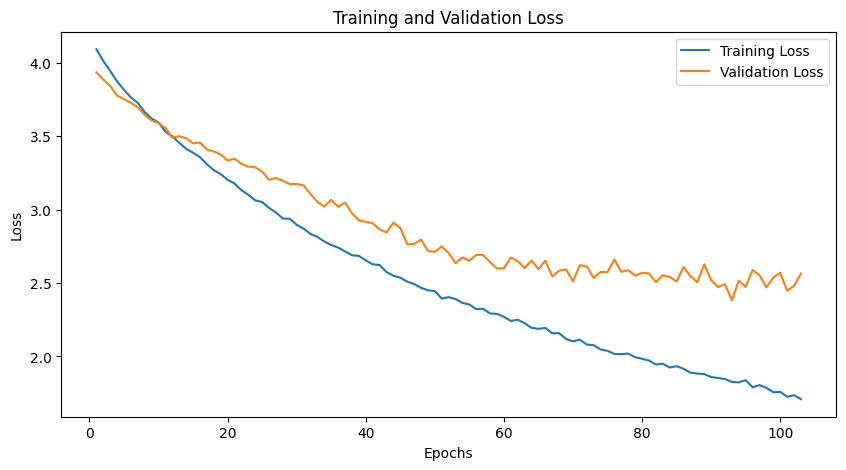

In [29]:
# Plot Losses
plt.figure(figsize=(10, 5))
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## 7.2. Accuracy graph

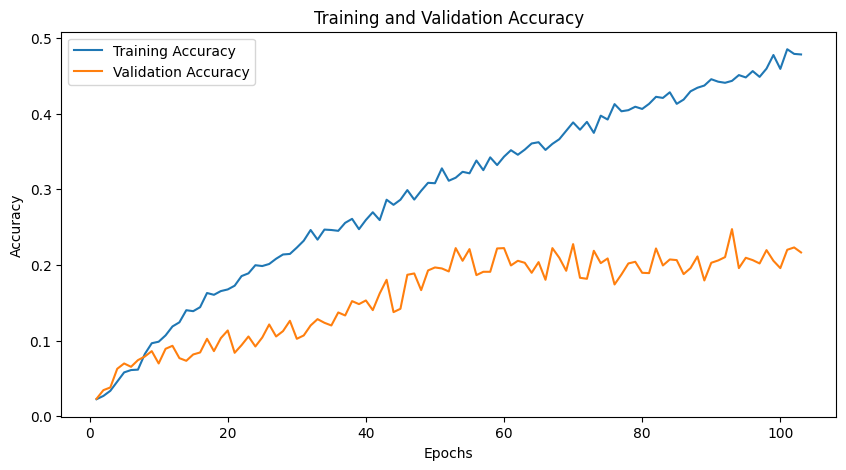

In [30]:
plt.figure(figsize=(10, 5))
plt.plot(epochs_range, train_accuracies, label='Training Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

## 7.3. Epoch duration graph

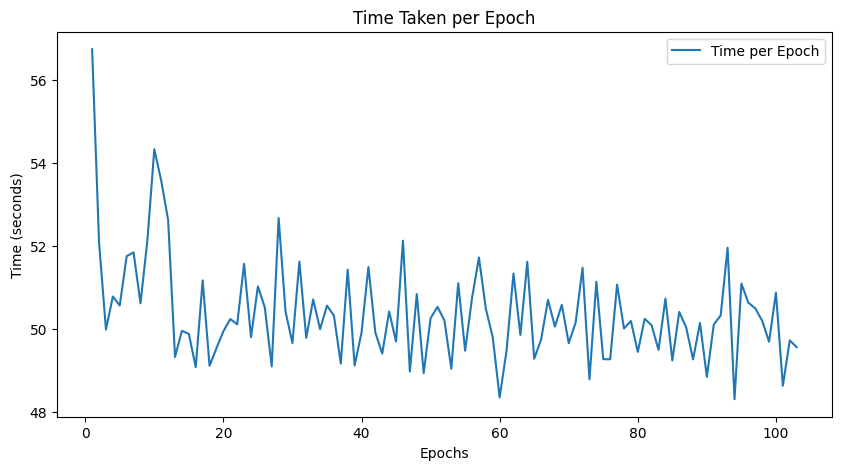

In [31]:
plt.figure(figsize=(10, 5))
plt.plot(epochs_range, epoch_times, label='Time per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Time (seconds)')
plt.title('Time Taken per Epoch')
plt.legend()
plt.show()

# 8. Test the model

## 8.1. Create & load model

In [32]:
torch.cuda.empty_cache()

model = UnoSymbolClassifier()
model.to(device, non_blocking=True)
model = torch.compile(model, backend="inductor")

In [33]:
stopped_early = False

# Load the best model (if saved during early stopping)
if stopped_early:
    model.load_state_dict(torch.load('../data/models/best_symbol_classifier.pth'))
else:
    model.load_state_dict(torch.load('../data/models/full_symbol_classifier.pth'))

/tmp/ipykernel_66714/3855329010.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('../data/models/full_symbol_classifier.pth'))


## 8.2. Test model

In [34]:
image_transform = v2.Compose([
    v2.Resize((512, 288)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=mean, std=std)
])

In [35]:
# Define class names
class_names = train_data.classes

In [153]:
# Specify the path to your image
image_path = '../data/validation_pool/P2G/frame_0074.jpg'  # Replace with your image path

# Load the image
image = Image.open(image_path).convert('RGB')

In [154]:
transformed_image = image_transform(image)

In [155]:
# Add batch dimension and move to device
input_tensor = transformed_image.unsqueeze(0).to(device, non_blocking=True)

In [156]:
# Set model to evaluation mode
model.eval()

# Make prediction
with torch.no_grad():
    output = model(input_tensor)
    _, predicted = torch.max(output, 1)

In [157]:
# Get predicted class
predicted_class = class_names[predicted.item()]
print(f'Predicted Class: {predicted_class}')

Predicted Class: P2G


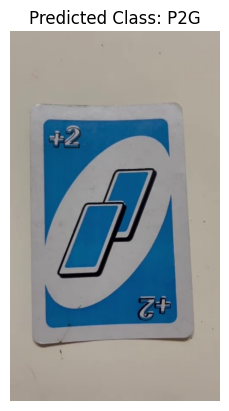

In [158]:
# Display the image and prediction
plt.imshow(image)
plt.title(f'Predicted Class: {predicted_class}')
plt.axis('off')
plt.show()